In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim import lr_scheduler
from random import *
import os
import cv2
import copy

## 데이터 생성

In [2]:
# class AlbumentationsDataset(Dataset):
#     def __init__(self, file_paths, labels, transform=None):
#         self.file_paths = file_paths
#         self.labels = labels
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.file_paths)

#     def __getitem__(self, idx):
#         label = self.labels[idx]
#         file_path = self.file_paths[idx]
        
#         # Read an image with OpenCV
#         image = cv2.imread(file_path)
        
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         start_t = time.time()
#         if self.transform:
#             augmented = self.transform(image=image) 
#             image = augmented['image']
#         total_time = (time.time() - start_t)
        
#         return image, label, total_time

In [36]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomAffine(30),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomAffine(30),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [37]:
data_dir = os.path.join(os.getcwd(), 'emnist')
image_datasets = {x: dset.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [38]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

## ResNet 모델 만들기

In [39]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv3 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(out_planes)
        self.conv4 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()

        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1), 
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(self.bn3(self.conv3(out)))
        out = F.relu(self.bn4(self.conv4(out)))
        out += self.shortcut(x)
        out = F.relu(out)

        return out

class cusomtomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(cusomtomResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(32, 3, stride=1)
        self.layer2 = self._make_layer(64, 3, stride=1)
        self.layer3 = self._make_layer(128, 3, stride=1)
        self.layer4 = self._make_layer(256, 3, stride=1)
        self.layer5 = self._make_layer(512, 3, stride=1)
        self.linear = nn.Linear(51200, num_classes)

    def _make_layer(self, out_planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, out_planes, stride))
            self.in_planes = out_planes
        
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = F.adaptive_avg_pool2d(out, output_size=10)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
#         print(out.shape)
        
        return out

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = cusomtomResNet().to(device)

In [41]:
print(model_ft)

cusomtomResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), 

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.1, patience=20)

In [43]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=8):


    global_info = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=10, verbose=True)
    for epoch in range(num_epochs):
        local_info = []
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':

                model.train()  # Set model to training mode
            else:

                model.eval()   # Set model to evaluate mode
                if epoch >0:
                    scheduler.step(val_loss)
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'val':
                val_loss = running_loss / dataset_sizes['val']
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            #(Variable(x).data).cpu().numpy()
            if phase == 'train':
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)
            else:
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)



            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        lr_get = get_lr(optimizer)
        print("Current learning rate : {:.8f}".format(lr_get))
        global_info.append(local_info)
        if phase =='val':
            early_stopping(epoch_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200)

Epoch 0/199
----------
train Loss: 28.2183 Acc: 0.1005
val Loss: 4967.5456 Acc: 0.0841
Current learning rate : 0.00500000
Validation loss decreased (inf --> 4967.545617).  Saving model ...
Epoch 1/199
----------
train Loss: 5.2324 Acc: 0.1268
val Loss: 3.6750 Acc: 0.1226
Current learning rate : 0.00500000
Validation loss decreased (4967.545617 --> 3.675012).  Saving model ...
Epoch 2/199
----------
train Loss: 5.0346 Acc: 0.1287
val Loss: 4.5362 Acc: 0.1274
Current learning rate : 0.00500000
EarlyStopping counter: 1 out of 10
Epoch 3/199
----------
train Loss: 4.8435 Acc: 0.1244
val Loss: 3.0253 Acc: 0.1394
Current learning rate : 0.00500000
Validation loss decreased (3.675012 --> 3.025324).  Saving model ...
Epoch 4/199
----------
train Loss: 2.7277 Acc: 0.1489
val Loss: 2.7227 Acc: 0.1683
Current learning rate : 0.00500000
Validation loss decreased (3.025324 --> 2.722653).  Saving model ...
Epoch 5/199
----------
train Loss: 2.4077 Acc: 0.1722
val Loss: 2.8360 Acc: 0.1659
Current lea

train Loss: 1.5063 Acc: 0.4688
val Loss: 1.5622 Acc: 0.4471
Current learning rate : 0.00500000
Validation loss decreased (1.563107 --> 1.562246).  Saving model ...
Epoch 48/199
----------
train Loss: 1.5226 Acc: 0.4571
val Loss: 1.5659 Acc: 0.4615
Current learning rate : 0.00500000
EarlyStopping counter: 1 out of 10
Epoch 49/199
----------
train Loss: 1.5193 Acc: 0.4700
val Loss: 1.5872 Acc: 0.4423
Current learning rate : 0.00500000
EarlyStopping counter: 2 out of 10
Epoch 50/199
----------
train Loss: 1.4923 Acc: 0.4632
val Loss: 1.6632 Acc: 0.4543
Current learning rate : 0.00500000
EarlyStopping counter: 3 out of 10
Epoch 51/199
----------
train Loss: 1.5230 Acc: 0.4681
val Loss: 1.5817 Acc: 0.4567
Current learning rate : 0.00500000
EarlyStopping counter: 4 out of 10
Epoch 52/199
----------
train Loss: 1.7597 Acc: 0.4308
val Loss: 2.1274 Acc: 0.4663
Current learning rate : 0.00500000
EarlyStopping counter: 5 out of 10
Epoch 53/199
----------
train Loss: 1.8444 Acc: 0.4491
val Loss: 1

In [21]:
torch.save(model_ft, './model/emnist_model2_resnet_3.pt')

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

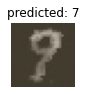

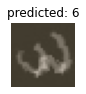

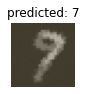

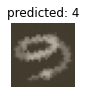

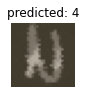

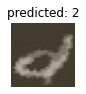

In [23]:
visualize_model(model_ft)

In [24]:
import natsort as nt
from PIL import Image
from torch.autograd import Variable 

def test_model():
    data_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    model_ft = torch.load('./model/emnist_model2_resnet_3.pt', map_location=device)
    path_test = os.path.join(os.getcwd(), 'emnist/test')
    image_list = nt.natsorted(os.listdir(path_test))
    output_list = []
    for i, images in enumerate(image_list):
        path_test_image = os.path.join(path_test, images)
        image = Image.open(path_test_image)
        image = data_transforms(image)
        image.unsqueeze_(dim=0)
        image = Variable(image)
        image = image.cuda(device)
        torch.no_grad()
        output = model_ft(image)
        output = torch.argmax(output, dim=1)
        output_list.append(output)
        
    return output_list

output = test_model()

In [25]:
submission = pd.read_csv('submission.csv')
submission.digit = torch.cat(output).detach().cpu().numpy()
submission.to_csv('./result/submission2_3.csv', index=False)